In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text

### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-18 03:52:56--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.01s   

2023-10-18 03:52:56 (118 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [87]:
df=pd.read_csv("housing.csv")

In [88]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2 we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.


In [89]:
df=df[(df.ocean_proximity=='<1H OCEAN') | (df.ocean_proximity=='INLAND')]

In [90]:
df=df.reset_index(drop=True)

In [91]:
df=df.fillna(0)

In [92]:
df.median_house_value=np.log1p(df.median_house_value)

In [93]:
df_full_train,df_test=train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val=train_test_split(df_full_train,test_size=0.25,random_state=1)

In [94]:
len(df_full_train),len(df_test),len(df_train),len(df_test)

(12549, 3138, 9411, 3138)

In [95]:
df_train=df_train.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

In [96]:
y_train=df_train.median_house_value
y_val=df_val.median_house_value
y_test=df_test.median_house_value

In [97]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [98]:
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-120.25,37.93,13.0,493.0,76.0,196.0,68.0,3.3750,INLAND
1,-118.40,34.00,10.0,1526.0,339.0,705.0,268.0,5.8083,<1H OCEAN
2,-121.67,38.85,46.0,645.0,131.0,410.0,122.0,1.7417,INLAND
3,-118.14,33.88,24.0,3305.0,982.0,2085.0,881.0,2.6641,<1H OCEAN
4,-118.11,33.92,34.0,1414.0,263.0,983.0,264.0,4.1767,<1H OCEAN


## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`

In [99]:
train_dicts=df_train.to_dict(orient='records')

dv=DictVectorizer(sparse=True)
X_train=dv.fit_transform(train_dicts)

In [100]:
dt=DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [101]:
val_dicts=df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [102]:
y_pred = dt.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

In [103]:
rmse

0.45168599736547216

In [104]:
print(export_text(dt, feature_names=list(dv.feature_names_)))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245
* 0.545
* 0.845


In [105]:
from sklearn.ensemble import RandomForestRegressor

In [106]:
rf = RandomForestRegressor(n_estimators=10, random_state=1,n_jobs=-1)

In [107]:
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [108]:
y_pred = rf.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

In [109]:
rmse

0.24495290030597147

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- 50
- 160

In [111]:
scores=[]
for n in range(10,201,10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    
    scores.append((n,rmse))
    
    
    
    

In [112]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

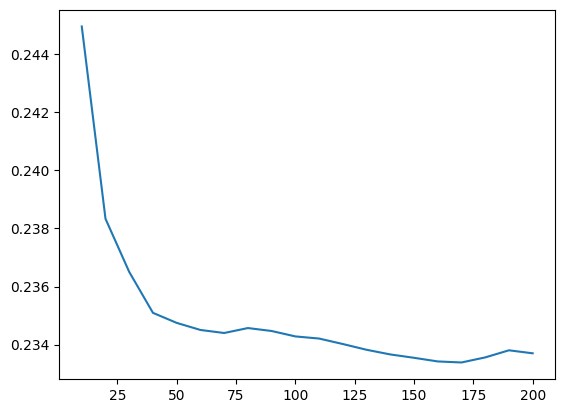

In [116]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

In [267]:
df_scores.iloc[::5]

,n_estimators,max_depth,rmse
0,10,10,0.250682
5,60,10,0.245221
10,110,10,0.245262
15,160,10,0.244459
20,10,15,0.245727
25,60,15,0.235624
30,110,15,0.235153
35,160,15,0.234297
40,10,20,0.245313
45,60,20,0.234794


## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20
* 25

In [128]:
scores=[]

for d in [10, 15, 20, 25]:
    for n in range(10,201,10):
        
        rf = RandomForestRegressor(n_estimators=n, max_depth=d,random_state=1,n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)

        scores.append((n,d,rmse))

In [129]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth','rmse'])

In [130]:
df_scores

,n_estimators,max_depth,rmse
0,10,10,0.250682
1,20,10,0.247455
2,30,10,0.246264
3,40,10,0.245029
4,50,10,0.245430
...,...,...,...
75,160,25,0.233395
76,170,25,0.233390
77,180,25,0.233572
78,190,25,0.233811


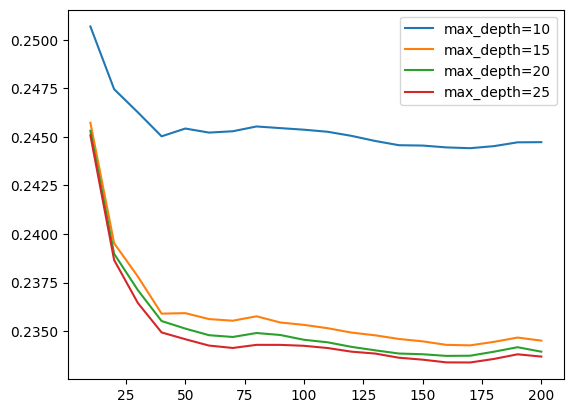

In [143]:
for d in [10, 15, 20, 25]:
    df_subset=df_scores[df_scores.max_depth==d]
    plt.plot(df_subset.n_estimators,df_subset.rmse,label='max_depth=%s' %d)
    
#plt.ylim(0.23,0.2375)
plt.legend()
    

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`

In [147]:
# Create the random forest regressor
rf=RandomForestRegressor(n_estimators=10,
                         max_depth=20,
                         random_state=1,
                         n_jobs=-1)

In [148]:
# Fit the model to your data
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [149]:
# Get the feature importances
feature_importances = rf.feature_importances_

In [150]:
feature_importances

array([0.01495348, 0.03019435, 0.10189142, 0.0861758 , 0.33566849,
       0.29247297, 0.07380644, 0.02682069, 0.01624481, 0.02177155])

In [152]:
# Create a dictionary to map feature names to their importance scores
feature_importance_dict = {feature_name: importance for feature_name, importance in zip(df_train.columns, feature_importances)}


In [154]:
# Find the most important feature
most_important_feature = max(feature_importance_dict, key=feature_importance_dict.get)


In [155]:
print("The most important feature is:", most_important_feature)

The most important feature is: total_bedrooms


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [159]:
import xgboost as xgb

In [170]:
features = list(dv.get_feature_names_out())


In [175]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [176]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [238]:
def parse_xgb_output(output):
    results=[]
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        
        results.append((it, train, val))
        
    columns = ['num_iter', 'train_rmse', 'val_rmse']
        
    df_results = pd.DataFrame(results, columns=columns)
        
    return df_results

In [252]:
scores={}

In [256]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [257]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

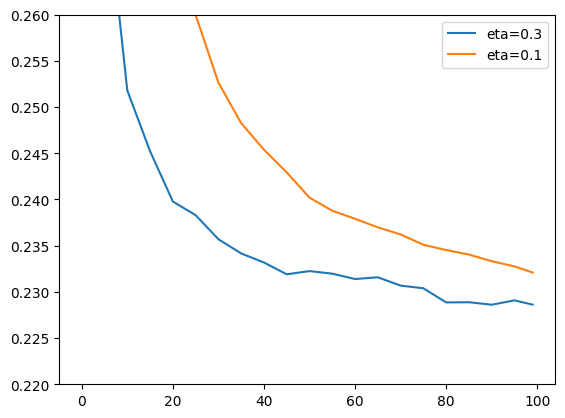

In [262]:
for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)

plt.ylim(0.22, 0.26)
plt.legend()